In [7]:
%matplotlib inline

from __future__ import print_function

import math
import cmath
import re
import os
import glob
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.python.data import Dataset
import seaborn as sns

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

# DEBUGGING AND OUTPUT
PLOT = True
SUMMARIZE = True
TEST = False

# NOTES
NOTES = ""

# Vars
target_label = "label"
id_label = "ImageId"
TYPE = "CNN"
OUTSTR = "A{:.4f}_Type{}_LR{}_S{}_B{}{}.csv"
LEARNING_STEPS = 2500
LEARNING_RATE = 0.01
BATCH_SIZE = 100

# PATHS
paths = {
    "Training":"/home/wesleytocs/.kaggle/competitions/digit-recognizer/train.csv",
    "Testing":"/home/wesleytocs/.kaggle/competitions/digit-recognizer/test.csv",
    "Submission":"/home/wesleytocs/.kaggle/competitions/digit-recognizer/sample_submission.csv",
}

In [12]:
# def cnn_model_fn(features, labels, mode):
#   """Model function for CNN."""
#   # Input Layer
#   input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

#   # Convolutional Layer #1
#   conv1 = tf.layers.conv2d(
#       inputs=input_layer,
#       filters=32,
#       kernel_size=[5, 5],
#       padding="same",
#       activation=tf.nn.relu)

#   # Pooling Layer #1
#   pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

#   # Convolutional Layer #2 and Pooling Layer #2
#   conv2 = tf.layers.conv2d(
#       inputs=pool1,
#       filters=64,
#       kernel_size=[5, 5],
#       padding="same",
#       activation=tf.nn.relu)
#   pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

#   # Dense Layer
#   pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
#   dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
#   dropout = tf.layers.dropout(
#       inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

#   # Logits Layer
#   logits = tf.layers.dense(inputs=dropout, units=10)

#   predictions = {
#       # Generate predictions (for PREDICT and EVAL mode)
#       "classes": tf.argmax(input=logits, axis=1),
#       # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
#       # `logging_hook`.
#       "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
#   }

#   if mode == tf.estimator.ModeKeys.PREDICT:
#     return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

#   # Calculate Loss (for both TRAIN and EVAL modes)
#   loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

#   # Configure the Training Op (for TRAIN mode)
#   if mode == tf.estimator.ModeKeys.TRAIN:
#     optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
#     train_op = optimizer.minimize(
#         loss=loss,
#         global_step=tf.train.get_global_step())
#     return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

#   # Add evaluation metrics (for EVAL mode)
#   eval_metric_ops = {
#       "accuracy": tf.metrics.accuracy(
#           labels=labels, predictions=predictions["classes"])}
#   return tf.estimator.EstimatorSpec(
#       mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

AttributeError: ("can't set attribute", 'occurred at index pixel0')

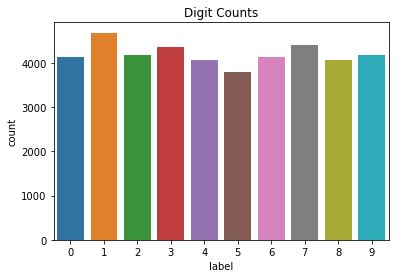

In [19]:
train_data = pd.read_csv(paths["Training"], sep=",").astype(np.int32)
train_data = train_data.reindex(np.random.permutation(train_data.index))
ax = sns.countplot(x="label", data=train_data)
ax.set_title("Digit Counts")
train_labels = np.asarray(train_data.pop(target_label), dtype=np.int32)
train_data = train_data / 255
train_data = np.asarray(train_data, dtype=np.float64)

t_size = int(0.8 * train_data.shape[0])

validation_data = train_data[t_size:]
validation_labels = train_labels[t_size:]
train_data = train_data[:t_size]
train_labels = train_labels[:t_size]

eval_data = pd.read_csv(paths["Testing"], sep=",")
eval_data = eval_data / 255
eval_data = np.asarray(eval_data, dtype=np.float64)
eval_labels = np.asarray(pd.read_csv(paths["Submission"], sep=",")["Label"], dtype=np.int32)

# Load training and eval data
# mnist = tf.contrib.learn.datasets.load_dataset("mnist")
# train_data = mnist.train.images  # Returns np.array
# train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
# eval_data = mnist.test.images  # Returns np.array
# eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

In [4]:
# print("TRAINING")
# print(train_data.shape)
# print(train_labels.shape)
# print("-" * 40)
# print("VALIDATION")
# print(validation_data.shape)
# print(validation_labels.shape)
# print("-" * 40)
# print("EVALUATION")
# print(eval_data.shape)
# print(eval_labels.shape)
# print(set(eval_labels))

TRAINING
(33600, 784)
(33600,)
----------------------------------------
VALIDATION
(8400, 784)
(8400,)
----------------------------------------
EVALUATION
(28000, 784)
(28000,)
{0}


In [5]:
# # Create the Estimator
# classifier = tf.estimator.Estimator(
#     model_fn=cnn_model_fn, model_dir="/tmp/mnist_convnet_model")

In [6]:
# # Train the model
# train_input_fn = tf.estimator.inputs.numpy_input_fn(
#     x={"x": train_data},
#     y=train_labels,
#     batch_size=BATCH_SIZE,
#     num_epochs=None,
#     shuffle=True)

In [7]:
# training_eval_input_fn = tf.estimator.inputs.numpy_input_fn(
#     x={"x": train_data},
#     y=train_labels,
#     num_epochs=1,
#     shuffle=False)
# validation_eval_input_fn = tf.estimator.inputs.numpy_input_fn(
#     x={"x": validation_data},
#     y=validation_labels,
#     num_epochs=1,
#     shuffle=False)

In [8]:
# periods = LEARNING_STEPS // 50
# steps_per_period = LEARNING_STEPS // periods
# t_accs = []
# v_accs = []
# t_lls = []
# v_lls = []
# print("Training model...\nMetrics:")
# print("\tPERIOD\tTYPE\tTRAIN.\tVALID.")
# for period in range(periods):
#     classifier.train(
#         input_fn=train_input_fn,
#         steps=steps_per_period)
#     training_stats = classifier.evaluate(input_fn=training_eval_input_fn)
#     validation_stats = classifier.evaluate(input_fn=validation_eval_input_fn)
#     t_ll = training_stats["loss"]
#     t_acc = 100 * training_stats["accuracy"]
#     v_ll = validation_stats["loss"]
#     v_acc = 100 * validation_stats["accuracy"]
#     print("\t{}\tLgLs\t{:.2f}\t{:.2f}".format(period, t_ll, v_ll))
#     print("\t\tAcc.\t{:.2f}%\t{:.2f}%\n".format(t_acc, v_acc))
#     t_lls.append(t_ll);
#     v_lls.append(v_ll)
#     t_accs.append(t_acc)
#     v_accs.append(v_acc)
# accuracy = classifier.evaluate(input_fn=validation_eval_input_fn)["accuracy"] * 100

Training model...
Metrics:
	PERIOD	TYPE	TRAIN.	VALID.
	0	LgLs	0.06	0.05
		Acc.	98.35%	98.49%

	1	LgLs	0.06	0.05
		Acc.	98.40%	98.45%

	2	LgLs	0.06	0.05
		Acc.	98.38%	98.43%

	3	LgLs	0.06	0.05
		Acc.	98.42%	98.43%

	4	LgLs	0.06	0.05
		Acc.	98.41%	98.38%

	5	LgLs	0.06	0.05
		Acc.	98.41%	98.39%

	6	LgLs	0.06	0.05
		Acc.	98.43%	98.37%

	7	LgLs	0.05	0.05
		Acc.	98.44%	98.37%

	8	LgLs	0.05	0.05
		Acc.	98.42%	98.40%

	9	LgLs	0.05	0.05
		Acc.	98.44%	98.42%

	10	LgLs	0.05	0.05
		Acc.	98.43%	98.37%

	11	LgLs	0.05	0.05
		Acc.	98.46%	98.40%

	12	LgLs	0.05	0.05
		Acc.	98.46%	98.36%

	13	LgLs	0.05	0.05
		Acc.	98.44%	98.44%

	14	LgLs	0.05	0.05
		Acc.	98.45%	98.39%

	15	LgLs	0.05	0.05
		Acc.	98.41%	98.39%

	16	LgLs	0.05	0.05
		Acc.	98.45%	98.37%

	17	LgLs	0.05	0.05
		Acc.	98.46%	98.37%

	18	LgLs	0.05	0.05
		Acc.	98.46%	98.35%

	19	LgLs	0.05	0.05
		Acc.	98.46%	98.33%

	20	LgLs	0.05	0.05
		Acc.	98.48%	98.40%

	21	LgLs	0.05	0.05
		Acc.	98.47%	98.42%

	22	LgLs	0.05	0.05
		Acc.	98.51%	98.42%

	23	LgLs	0.05

Final accuracy (on validation data): 98.4048%


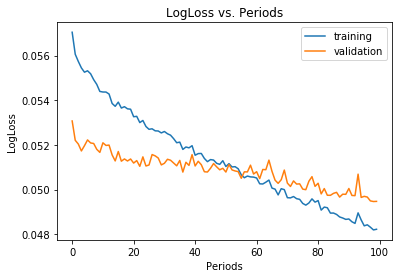

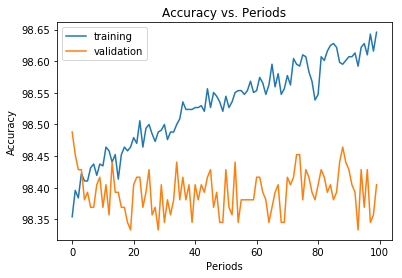

In [9]:
# print("Final accuracy (on validation data): {:.4f}%".format(accuracy))

# # Output a graph of loss metrics over periods.
# plt.ylabel("LogLoss")
# plt.xlabel("Periods")
# plt.title("LogLoss vs. Periods")
# plt.plot(t_lls, label="training")
# plt.plot(v_lls, label="validation")
# plt.legend()
# plt.show()

# # Output a graph of accuracy over periods.
# plt.ylabel("Accuracy")
# plt.xlabel("Periods")
# plt.title("Accuracy vs. Periods")
# plt.plot(t_accs, label="training")
# plt.plot(v_accs, label="validation")
# plt.legend()
# plt.show()

In [10]:
# # Evaluate the model and print results
# eval_input_fn = tf.estimator.inputs.numpy_input_fn(
#     x={"x": eval_data},
#     y=eval_labels,
#     num_epochs=1,
#     shuffle=False)
# stats = classifier.evaluate(input_fn=eval_input_fn)
# t_accuracy = 100 * stats["accuracy"]
# print("Accuracy on evaluation data (expected ~10%): {:.2f}%".format(t_accuracy))

Accuracy on evaluation data (expected ~10%): 9.93%


In [11]:
# # Make Predictions and output the results
# predictions = np.array([item['classes'] for item in classifier.predict(input_fn=eval_input_fn)])
# ids = np.array([i + 1 for i in range(len(predictions))])
# output = pd.DataFrame({id_label:ids, target_label:predictions}, dtype=np.int32)

In [12]:
# if not TEST:
#     name = OUTSTR.format(accuracy, TYPE, LEARNING_RATE, LEARNING_STEPS, BATCH_SIZE,"_" + NOTES if NOTES else "")
#     print("Outputting to: '{}'".format(name))
#     output.to_csv(name, index=False)

Outputting to: 'A98.4048_TypeCNN_LR0.001_S5000_B100.csv'
